# Cockroach

This tutorial will show you how to get a Cockroach instance up and running locally to test JupySQL. You can run this in a Jupyter notebook.

## Pre-requisites

To run this tutorial, you need to install following Python packages:

In [1]:
%pip install sqlalchemy-cockroachdb --quiet

Note: you may need to restart the kernel to use updated packages.


## Start Cockroach instance

We fetch the official image, create a new database, and user (this will take 1-2 minutes):

In [59]:
%%bash
docker run --rm -d --name=roach \
-p 8080:8080 -p 26257:26257 \
cockroachdb/cockroach:latest \
start-single-node --insecure

f6fa357317912bfbcc83adae20bff789915f84f59645daab47ecc01d530d0a0b


## Load sample data

Now, let's fetch some sample data. We'll be using the [NYC taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page):

In [60]:
import pandas as pd

df = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
)
df.shape

(1369769, 19)

In [63]:
from sqlalchemy import create_engine

engine = create_engine(
    "cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable"
)
df.sample(1000).to_sql(
    name="taxi", con=engine, chunksize=1000, if_exists="replace", index=True
)
engine.dispose()

## Query

Now, let's start JupySQL, authenticate and start querying the data!

In [64]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [67]:
%sql cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable

```{important}
If the cell above fails, you might have some missing packages. Message us on [Slack](https://ploomber.io/community) and we'll help you!
```

List the tables in the database:

In [68]:
%sqlcmd tables

Name
taxi


List columns in the taxi table:

In [69]:
%sqlcmd columns --table taxi

name,type,nullable,default,autoincrement,is_hidden
index,INTEGER,True,None,False,False
VendorID,INTEGER,True,None,False,False
tpep_pickup_datetime,TIMESTAMP,True,None,False,False
tpep_dropoff_datetime,TIMESTAMP,True,None,False,False
passenger_count,FLOAT,True,None,False,False
trip_distance,FLOAT,True,None,False,False
RatecodeID,FLOAT,True,None,False,False
store_and_fwd_flag,VARCHAR,True,None,False,False
PULocationID,INTEGER,True,None,False,False
DOLocationID,INTEGER,True,None,False,False


Query our data:

In [70]:
%%sql
SELECT COUNT(*) FROM taxi

*  cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable
1 rows affected.


count
1000


## Parametrize queries


In [71]:
threshold = 10

In [72]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

*  cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable
1 rows affected.


count
949


In [73]:
threshold = 0.5

In [74]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

*  cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable
1 rows affected.


count
45


## CTEs


In [75]:
%%sql --save many_passengers --no-execute
SELECT *
FROM taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93

*  cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable
Skipping execution...


In [76]:
%%sql --save trip_stats --with many_passengers
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers

*  cockroachdb+psycopg2://root@localhost:26257/defaultdb?sslmode=disable
1 rows affected.


min,avg,max
0.4,1.8566666666666674,11.56


This is what JupySQL executes:

In [77]:
query = %sqlrender trip_stats
print(query)

WITH many_passengers AS (
SELECT *
FROM taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93)
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers


## Plotting

<Axes: title={'center': "'trip_distance' from 'taxi'"}, xlabel='trip_distance', ylabel='Count'>

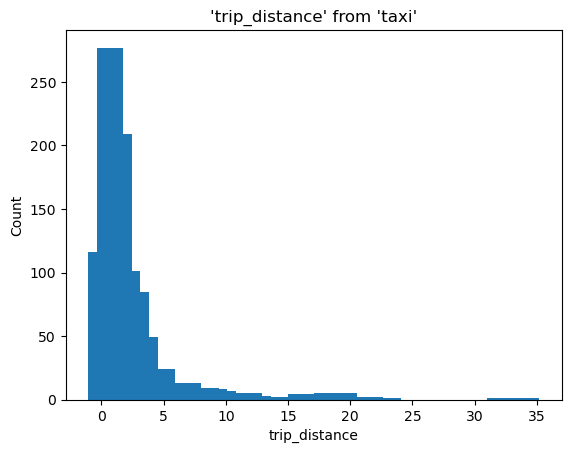

In [78]:
%sqlplot histogram --table taxi --column trip_distance

## Clean up

To stop and remove the container:

In [79]:
! docker container ls

CONTAINER ID   IMAGE                          COMMAND                  CREATED              STATUS              PORTS                                                                                      NAMES
f6fa35731791   cockroachdb/cockroach:latest   "/cockroach/cockroac…"   About a minute ago   Up About a minute   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 0.0.0.0:26257->26257/tcp, :::26257->26257/tcp   roach


In [80]:
%%capture out
! docker container ls --filter name=roach --quiet

In [81]:
container_id = out.stdout.strip()
print(f"Container id: {container_id}")

Container id: f6fa35731791


In [82]:
! docker container stop {container_id}

f6fa35731791


In [83]:
! docker container rm {container_id}

Error: No such container: f6fa35731791


In [84]:
! docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES
